Load libraries

In [88]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

Load stock data

In [84]:
# df = pd.read_csv('data/TSLA.csv')
# df = df.iloc[:100]

Define some helpful functions

In [105]:
def calculate_support_resistance(data, window):
    data['Support'] = data['Low'].rolling(window=window).min()
    data['Resistance'] = data['High'].rolling(window=window).max()
    return data['Support'].iloc[-1], data['Resistance'].iloc[-1]

In [31]:
def lorentzian_distance(x, y):
    return np.log(1 + (x - y)**2)

In [37]:
support, resistance = calculate_support_resistance(df, 500)
print(support)
print(resistance)

291.46
311.8782


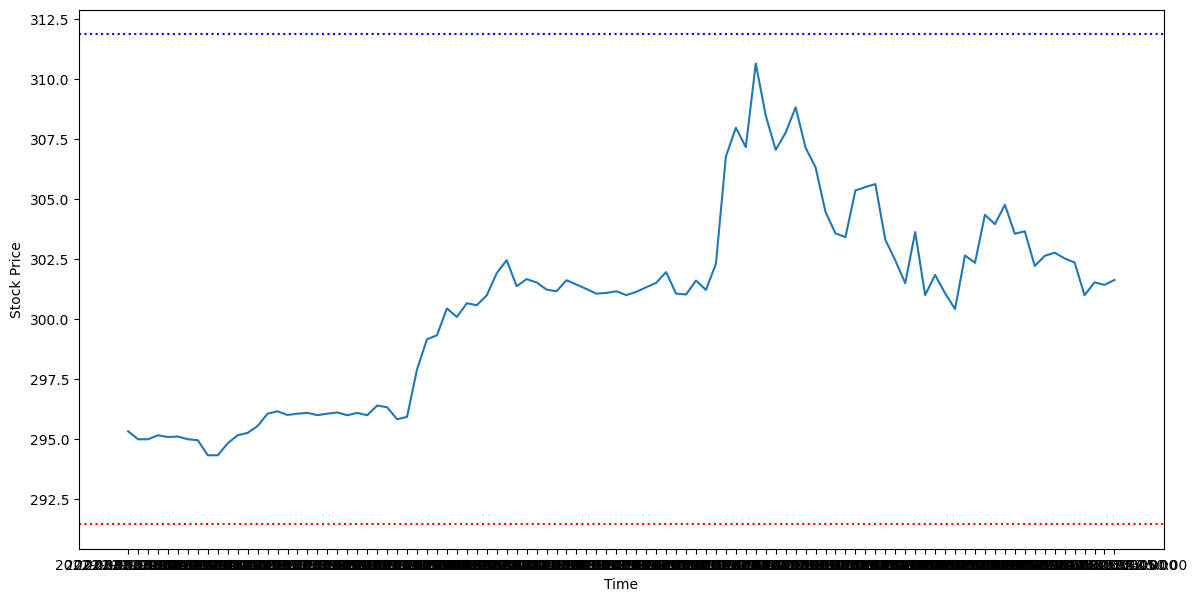

In [85]:
plt.figure(figsize=(14,7))
plt.plot(df['timestamp'], df['close'], label='Actual Prices')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.axhline(y=resistance, linestyle = 'dotted', color = 'b')
plt.axhline(y=support, linestyle = 'dotted', color = 'r')
plt.show()

In [72]:
def detect_trend(index, data, order=1):
    result = np.polyfit(index, list(data), order)
    slope = result[-2]
    return float(slope)

In [106]:
def calculate_macd(data):
    data.ta.macd(close='Close', fast=12, slow=26, append=True)

In [107]:
def calculate_rsi(data, period=14):
    data['Change'] = data['Close'].diff()
    data['Gain'] = data['Change'].clip(lower=0)
    data['Loss'] = data['Change'].clip(upper=0).abs()
    data['Avg_Gain'] = data['Gain'].rolling(window=period).mean()
    data['Avg_Loss'] = data['Loss'].rolling(window=period).mean()
    data['RSI'] = 100 - (100 / (1 + (data['Avg_Gain'] / data['Avg_Loss'])))

              timestamp      open      high       low     close  volume  \
0   2022-08-01 04:00:00  296.6667  296.6667  293.3333  295.3333   11466   
1   2022-08-01 04:05:00  295.2700  295.3333  295.0000  295.0000    5631   
2   2022-08-01 04:10:00  295.3700  295.3700  295.0000  295.0000    1029   
3   2022-08-01 04:15:00  295.1667  295.1667  295.1667  295.1667    1800   
4   2022-08-01 04:20:00  295.0633  295.0933  295.0633  295.0933     717   
..                  ...       ...       ...       ...       ...     ...   
95  2022-08-01 12:30:00  302.5066  302.6850  301.6667  302.3667  384867   
96  2022-08-01 12:35:00  302.3533  302.6667  300.9967  301.0000  452892   
97  2022-08-01 12:40:00  301.0333  301.6633  300.6867  301.5390  382443   
98  2022-08-01 12:45:00  301.6600  301.8300  301.1042  301.4367  288900   
99  2022-08-01 12:50:00  301.5567  301.8267  301.2867  301.6377  240336   

    MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  change    gain    loss  \
0            NaN         

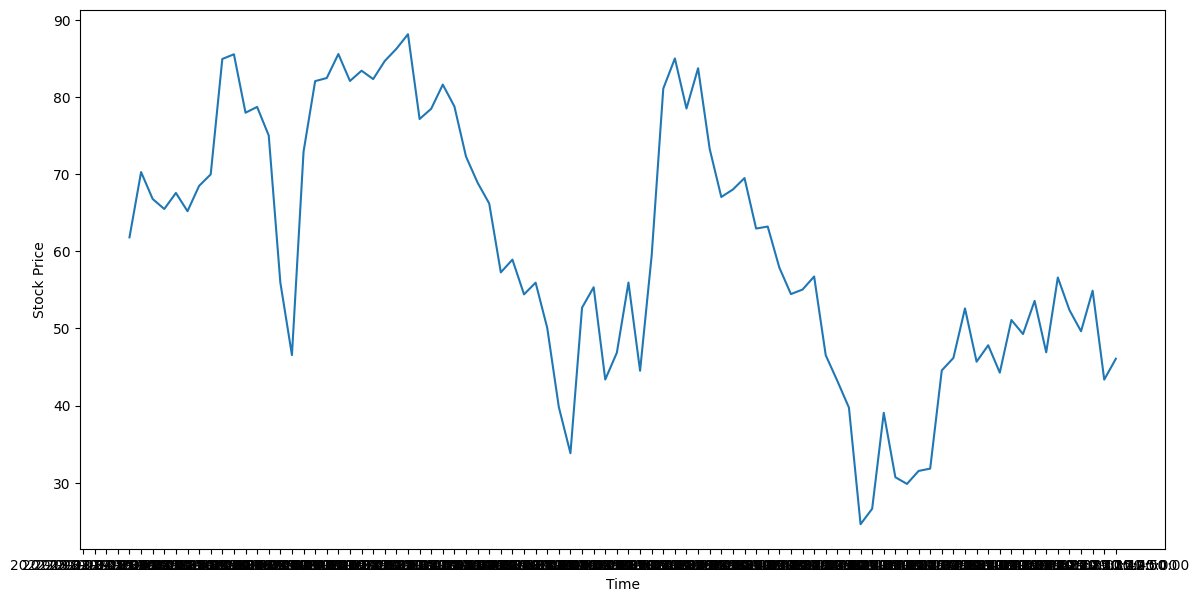

In [98]:
calculate_macd(df)
calculate_rsi(df)
print(df)

plt.figure(figsize=(14,7))
# plt.plot(df['timestamp'], df['close'], label='Actual Prices')
plt.ylabel('Stock Price')
plt.xlabel('Time')
# plt.axhline(y=resistance, linestyle = 'dotted', color = 'b')
# plt.axhline(y=support, linestyle = 'dotted', color = 'r')
plt.plot(df['timestamp'], df['rsi'], label='RSI')
# plt.plot(df['timestamp'], df['MACD_12_26_9'], label='MACD')
plt.show()

In [86]:
index = df.index.tolist()
data = df['close'].tolist()

In [87]:
print(detect_trend(index, data))

0.1041858865886589


Sample Scenario

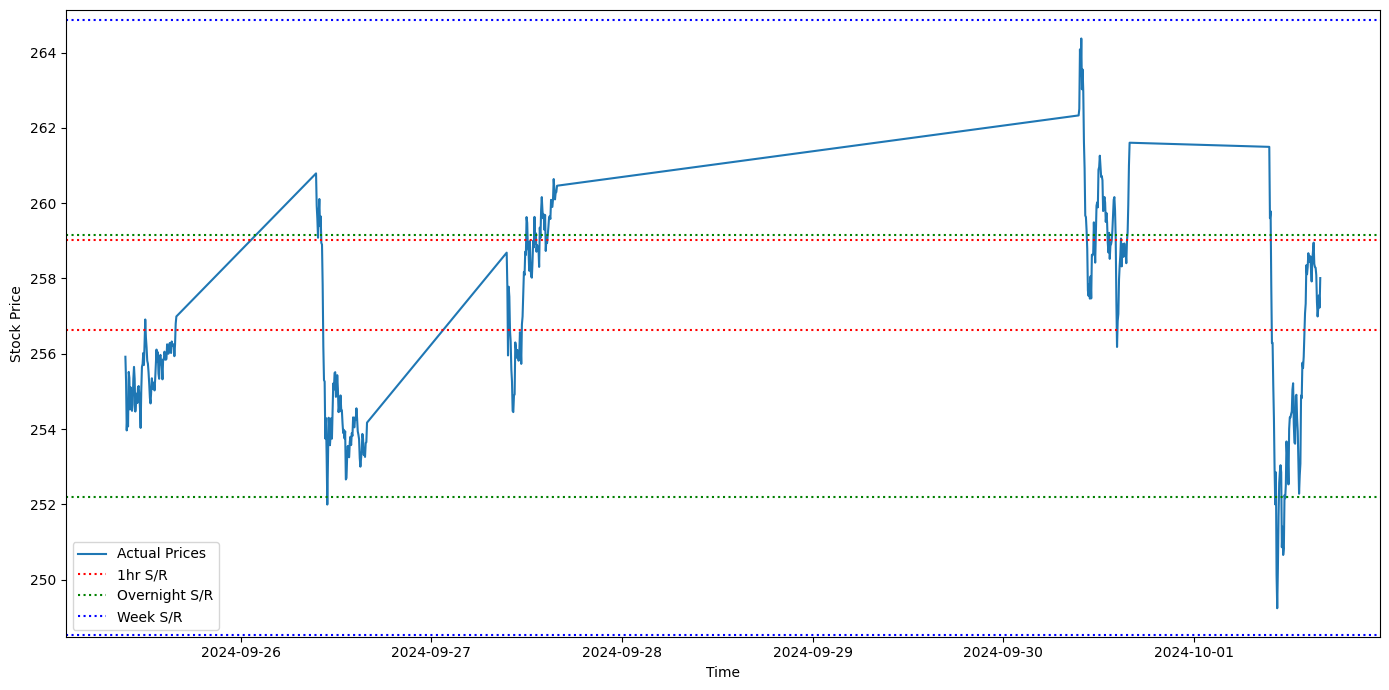


Current Price: 258.02

MACD: 0.35
RSI: 47.77
Neutral

Overnight trend: Upward
Overall trend: Upward

Resistances at 259.02, 259.15, 264.86
Supports at 256.63, 252.2, 248.53



In [140]:
# TODO: Replace this with AlphaVantage for overnight info

# Load recent data
current_data = yf.Ticker('TSLA')
df = yf.Ticker('TSLA').history(period='5d', interval='5m')

# Calculate trends
index = np.arange(len(df))
data = df['Close'].tolist()
trend = detect_trend(index, data)
trend_summary = 'Neutral'
if trend > 0:
    trend_summary = 'Upward'
elif trend < 0:
    trend_summary = 'Downward'

overnight_len = int(len(df) / 5)
overnight = df.iloc[-overnight_len:]
index = np.arange(len(overnight))
data = overnight['Close'].tolist()
overnight_trend = detect_trend(index, data)
overnight_trend_summary = 'Neutral'
if overnight_trend > 0:
    overnight_trend_summary = 'Upward'
elif overnight_trend < 0:
    overnight_trend_summary = 'Downward'

# Calculate MACD
calculate_macd(df)
macd = df['MACD_12_26_9'].iloc[-1]

# Calculate RSI
calculate_rsi(df)
rsi = df['RSI'].iloc[-1]
overbought = rsi >= 70
oversold = rsi <= 30
rsi_summary = 'Neutral'
if overbought:
    rsi_summary = 'Overbought, possible downward movement'
elif oversold:
    rsi_summary = 'Oversold, possible upward movement'

# Calculate supports/resistances
support_past_hour, resistance_past_hour = calculate_support_resistance(df, 12)
support_past_night, resistance_past_night = calculate_support_resistance(df, 39)
support_past_week, resistance_past_week = calculate_support_resistance(df, len(df))

# Plot some data
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Actual Prices')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.axhline(y=support_past_hour, linestyle = 'dotted', color = 'r', label='1hr S/R')
plt.axhline(y=resistance_past_hour, linestyle = 'dotted', color = 'r')

plt.axhline(y=support_past_night, linestyle = 'dotted', color = 'g', label='Overnight S/R')
plt.axhline(y=resistance_past_night, linestyle = 'dotted', color = 'g')

plt.axhline(y=support_past_week, linestyle = 'dotted', color = 'b', label='Week S/R')
plt.axhline(y=resistance_past_week, linestyle = 'dotted', color = 'b')
plt.legend()
plt.tight_layout()
plt.show()

summary = f"""
Current Price: {current_data.info['currentPrice']}

MACD: {round(macd, 2)}
RSI: {round(rsi, 2)}
{rsi_summary}

Overnight trend: {overnight_trend_summary}
Overall trend: {trend_summary}

Resistances at {round(resistance_past_hour, 2)}, {round(resistance_past_night, 2)}, {round(resistance_past_week, 2)}
Supports at {round(support_past_hour, 2)}, {round(support_past_night, 2)}, {round(support_past_week, 2)}
"""
print(summary)